In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from tqdm.notebook import tqdm
import scipy
import numba
import molsim
%load_ext line_profiler

<div style="max-width: 1000px; margin-left: 0; margin-right: auto; line-height: 1.6;">

# Exercise 3: Coupled harmonic oscillators
Consider a system of $N$ harmonic oscillators with a total energy
$U$. A single harmonic oscillator has energy levels 0, ϵ, 2ϵ, · · · , ∞ (ϵ > 0). All harmonic oscillators in the
system can exchange energy.


<img src="./figure/oscillator.png" alt="示例图片" style="display: block; margin: auto; width:80%;" >


**Figure 1.A system of $N$ harmonic oscillators with a total energy
$U$.**


<div style="max-width: 1000px; margin-left: 0; margin-right: auto; line-height: 1.6;">

## Question 1
Invent a computational scheme for the update of the system at constant total energy ($U$). Compare your scheme with the scheme that is incorporated into the given computer code. (You only need to describe the idea of your computational scheme)

### Answer
Imagine we treat all these harmonic osscilators as particles with at their respective energy levels. We choose a particle at random and then swap it with another particle in its vicinity (in $\Delta x$ range). If we consider this as an NVE system we can define an acceptance criteria as $\operatorname{acc}(o \to n) = \operatorname{min}(1,\; \exp{(-\beta\Delta U)})$. This acceptance function is shown to agree with Detailed Balance and so the Monte Carlo simulation will approach a limiting distribution.


In [3]:
import random
#@numba.jit
def NVE(numberOfOscillators, numberOfCycles, totalEnergy):
    """Calculate the distribution of energy in a system of oscillators for a fixed total energy

    Parameters:
        -numberOfOscillators (int): Number of oscillators in the system.
        -numberOfCycles (int): Number of cycles to run the simulation.
        -totalEnergy (int): Total energy to be distributed among the oscillators.

    Returns:
        np.ndarray: Array containing the energy distribution of the oscillators over the cycles.
    """
    random.seed(0)
    initSteps = numberOfCycles // 2
    sum = 0.0
    count = 0.0
    oscillator = np.zeros(numberOfOscillators, dtype=np.int32)
    distribution = np.zeros(totalEnergy + 1, dtype=np.float64)

    # Distribute the total energy among oscillators
    for energy in tqdm(range(totalEnergy), desc="Distributing energy",ncols=totalEnergy, leave=False):
        oscillator[energy % numberOfOscillators] += 1

    for cycle in tqdm(range(1, numberOfCycles), desc="Running simulation", ncols=numberOfCycles, leave=False):
        for _ in range(numberOfOscillators):
            # Select two oscillators
            oscA = random.randint(0, numberOfOscillators-1)
            oscB = random.randint(0, numberOfOscillators-1)
            oscB = oscB if oscB != oscA else (oscB + 1) % numberOfOscillators
            #oscA, oscB = np.random.randint(0, numberOfOscillators, 2)

            #oscA, oscB = np.random.choice(numberOfOscillators, 2, replace=False)

            # Choose a random exchange direction
            #flip = -1 if np.random.rand() < 0.5 else 1
            flip = -1 if random.random() < 0.5 else 1

            # If energy will not go negative, accept exchange
            if min([oscillator[oscA] + flip, oscillator[oscB] - flip]) >= 0.0:
                oscillator[oscA] += flip
                oscillator[oscB] -= flip

            # Update the distribution after half the cycles
            if cycle > initSteps:
                distribution[oscillator[0]] += 1.0
                sum += oscillator[0]
                count += 1.0

    return sum / count, distribution / count

<div style="max-width: 1000px; margin-left: 0; margin-right: auto; line-height: 1.6;">

## Question 2
Investigate the plot of the energy distribution of the first oscillator as a function of the number of oscillators for a constant value of $U/N$ . Which distribution is recovered when $N$ becomes  large ? What is the function of the other $N − 1$ harmonic oscillators? Explain.


We expect that as N increases and we keep the energy constant we should approch a Boltzman distribution. The other N-1 osscilators serve as a large heat bath/enery reservoir for the first osscilator

Distributing energy:   0%|                                                                                    …

Running simulation:   0%|                                                                                     …

Distributing energy:   0%|                                                                                    …

Running simulation:   0%|                                                                                     …

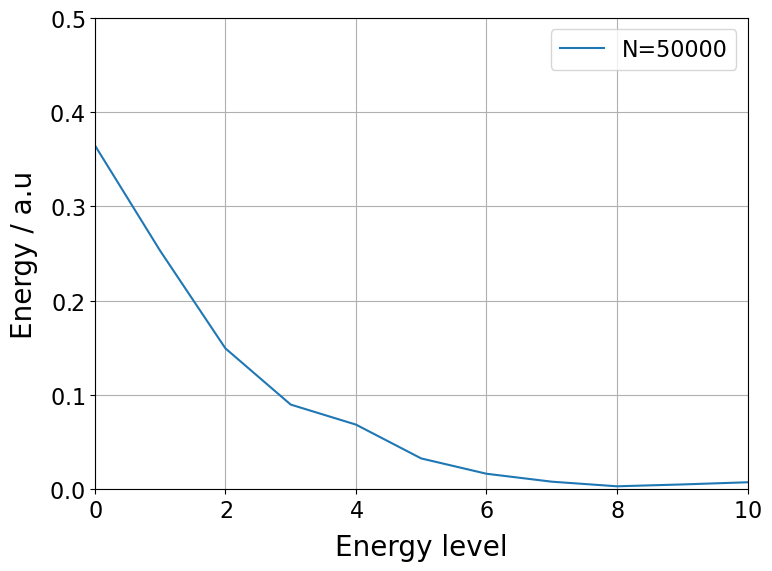

In [5]:
'''
The code takes about 3 minutes to run with the reasonable parameters, if you takes too long to run, you can reduce the number.
'''
nve_cycles = 2000
oscillatorNumbers = [50_000]
energyPerOscillator = 2
energy, distribution = NVE(oscillatorNumbers[0], nve_cycles, oscillatorNumbers[0] * energyPerOscillator)
np.save("distribution.npy", distribution)
np.save("energy.npy", energy)

fig, ax = plt.subplots()

for numberOfOscillators in oscillatorNumbers:
    energy, distribution = NVE(numberOfOscillators, nve_cycles, numberOfOscillators * energyPerOscillator)
    ax.plot(distribution, label=f"N={numberOfOscillators}")

ax.set_xlabel("Energy level", fontsize=20)
ax.set_ylabel("Energy / a.u", fontsize=20)
ax.set_xlim([0, 10])
ax.set_ylim([0, 0.5])
ax.legend()

<div style="max-width: 1000px; margin-left: 0; margin-right: auto; line-height: 1.6;">

## Question 3
Let’s do our first small Monte Carlo program to explicitly measure the Boltzmann distribution (more on Monte Carlo tomorrow). Metropolis MC employ Markov chains to generate states with probability exp ($−\beta U$) and counts them equally. Here, we generate a chain of states by making modifications of the current state by attempting to change the energy and applying an acceptance/rejection criteria. The new state will be accepted using:

\begin{equation}
p_{acc} = \min(1, \exp [-\beta \Delta U])
\end{equation}

To obey detailed balance, we decide random whether to increase the first and decrease the other, or vice versa.

Run the NVT code. How would you compare this result the NVE result (mentioned in Quesion 2)? Finished the implementation, and verify the result. (Note: these two result are the energy distribution of a single oscillator at the same averge energy)

Both of these seem to approach the same Boltzman distributution $P(E) \propto e^{E \over k_B T }$

In [10]:
# @numba.jit
def NVT(Beta, numberOfOscillators, numberOfCycles):
    """Calculate the distribution of energy in a system of oscillators for a fixed total energy

    Parameters:
        -Beta (float): Inverse temperature
        -numberOfOscillators (int): Number of oscillators in the system.
        -numberOfCycles (int): Number of cycles to run the simulation.

    Returns:
        np.ndarray: Array containing the energy distribution of an oscillator over the cycles.
    """
    initSteps = int(np.floor(0.5 * numberOfCycles))
    sum = np.double(0.0)
    count = np.double(0.0)
    oscillator = int(0)
    distribution = np.zeros(1000, dtype=np.float64)

    for cycle in tqdm(range(1, numberOfCycles), desc="Running simulation", ncols=numberOfCycles, leave=False):
        for _ in range(numberOfOscillators):
            # Choose a random exchange direction
            flip = -1 if np.random.rand() < 0.5 else 1

            # If energy will not go negative, accept exchange
            if (oscillator + flip >= 0) and (np.random.rand() < np.exp(-Beta * flip)):
                oscillator += flip

            # Update the distribution after half the cycles
            if cycle > initSteps:
                distribution[oscillator] += 1.0
                sum += oscillator
                count += 1.0

    return sum / count, distribution / count

In [11]:
numberOfOscillators = 10_000
numberOfCyles = 10000
beta = 0.5

average_energy_nvt, distribution_nvt = NVT(beta, numberOfOscillators, numberOfCyles)
print(f"average energy NVT: {average_energy_nvt}")

# start refactor
computed_total_energy = average_energy_nvt*numberOfOscillators 
average_energy_nve, distribution_nve = NVE(numberOfOscillators, numberOfCyles, int(computed_total_energy))
# end refactor
print(f"Computed total energy: {computed_total_energy}")
print(f"average energy NVE: {average_energy_nve}")

Running simulation:   0%|                                                                                     …

average energy NVT: 1.541927225445089


Distributing energy:   0%|                                                                                    …

Running simulation:   0%|                                                                                     …

Computed total energy: 15419.27225445089
average energy NVE: 1.5323214842968593


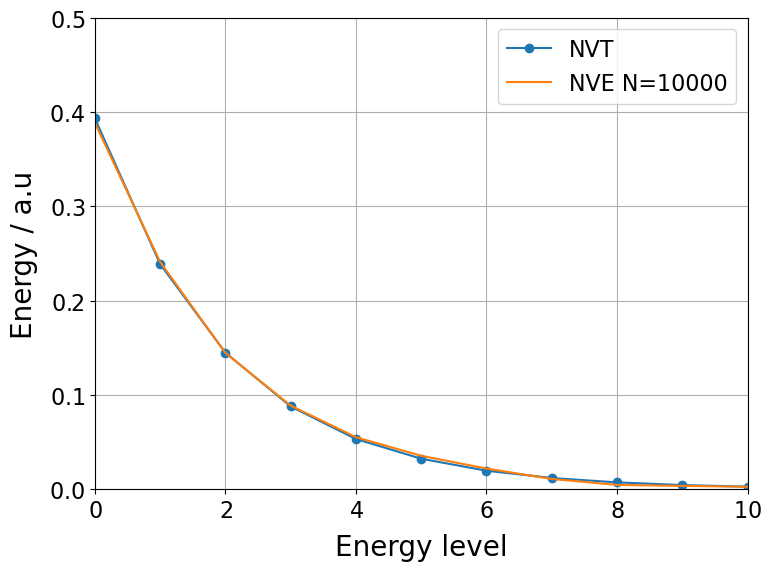

In [13]:
fig, ax = plt.subplots()
ax.plot(distribution_nvt, label="NVT", marker="o")
ax.plot(distribution_nve, label=f"NVE N={numberOfOscillators}")
ax.set_xlabel("Energy level", fontsize=20)
ax.set_ylabel("Energy / a.u", fontsize=20)
ax.set_xlim([0, 10])
ax.set_ylim([0, 0.5])
ax.legend()

<div style="max-width: 1000px; margin-left: 0; margin-right: auto; line-height: 1.6;">

## Question 4
Can you explain the phenomenon you see in Question 3? How does this exercise relate to the derivation of the Boltzmann distribution for a system at temperature $T$ on page 27-28 of
reference book (You can download in the moodle)?